In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 79s 1us/step


In [3]:
PATH

'C:\\Users\\VICTUS\\.keras\\datasets\\cats_and_dogs_filtered'

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [5]:
train_dir

'C:\\Users\\VICTUS\\.keras\\datasets\\cats_and_dogs_filtered\\train'

In [6]:
validation_dir

'C:\\Users\\VICTUS\\.keras\\datasets\\cats_and_dogs_filtered\\validation'

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [10]:
train_dataset.class_names

['cats', 'dogs']

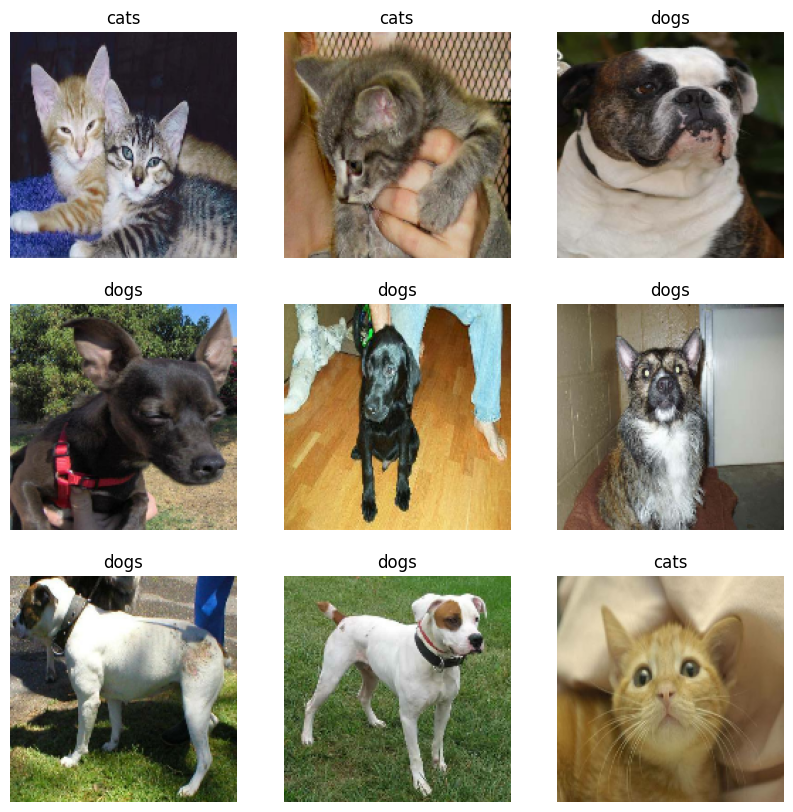

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 32


In [14]:
# move 20% of validation to a test set.
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [15]:
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of test batches: 6


In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 26


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

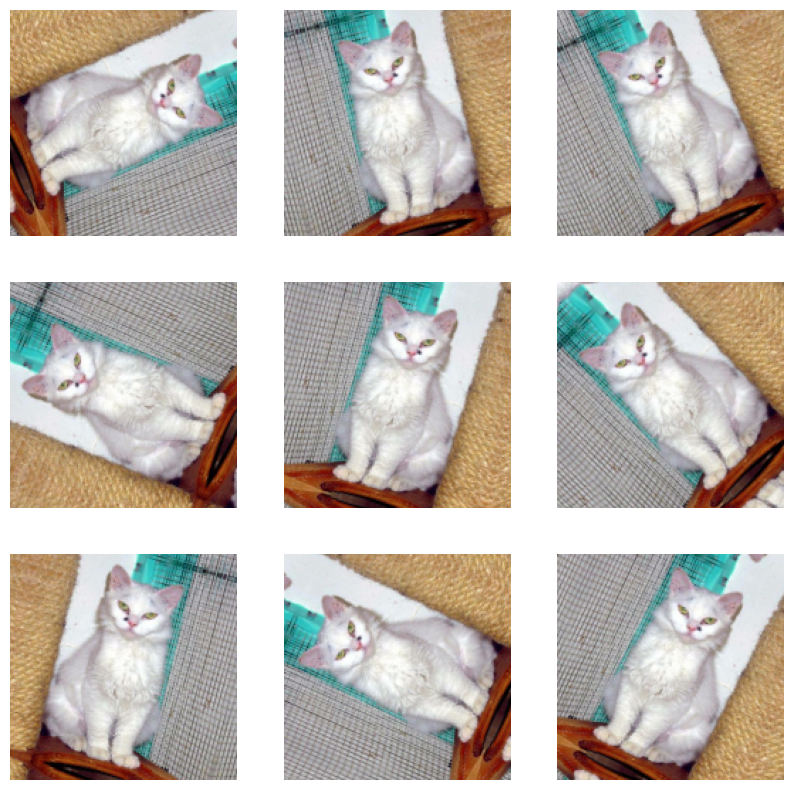

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 9s 1us/step


In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [23]:
#This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
image_batch, label_batch = next(iter(train_dataset)) # A batch of images. # The corresponding labels for the images in the batch
feature_batch = base_model(image_batch) # The model processes the images and outputs a set of feature vectors for each image in the batch.
print(feature_batch.shape)

# These 1280 numbers represent the learned features from the image.
# (32, 5, 5, 1280)): This output indicates that the base_model is not only extracting features but also preserving some spatial information.
# Here, each image in the batch is represented by a 5x5 grid of feature vectors, each of dimension 1280.  This is often seen in convolutional
#models before the global average pooling layer.

(32, 5, 5, 1280)


In [24]:
base_model.trainable = False

## To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
#It means that for each image in the batch (32 in this example), the base_model has extracted a feature vector of length 1280.

(32, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [28]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [29]:
#tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [31]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 6s 199ms/step - loss: 0.8839 - accuracy: 0.3812


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.38


In [33]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 21s 305ms/step - loss: 0.8066 - accuracy: 0.5005 - val_loss: 0.6189 - val_accuracy: 0.6634
Epoch 2/10
63/63 [==============================] - 19s 298ms/step - loss: 0.6066 - accuracy: 0.6790 - val_loss: 0.4506 - val_accuracy: 0.8230
Epoch 3/10
63/63 [==============================] - 19s 294ms/step - loss: 0.4840 - accuracy: 0.7940 - val_loss: 0.3502 - val_accuracy: 0.8824
Epoch 4/10
63/63 [==============================] - 19s 301ms/step - loss: 0.4075 - accuracy: 0.8335 - val_loss: 0.2848 - val_accuracy: 0.9121
Epoch 5/10
63/63 [==============================] - 19s 295ms/step - loss: 0.3424 - accuracy: 0.8690 - val_loss: 0.2428 - val_accuracy: 0.9282
Epoch 6/10
63/63 [==============================] - 19s 294ms/step - loss: 0.3115 - accuracy: 0.8775 - val_loss: 0.2143 - val_accuracy: 0.9369
Epoch 7/10
63/63 [==============================] - 19s 296ms/step - loss: 0.2919 - accuracy: 0.8870 - val_loss: 0.1816 - val_accuracy: 0.9542

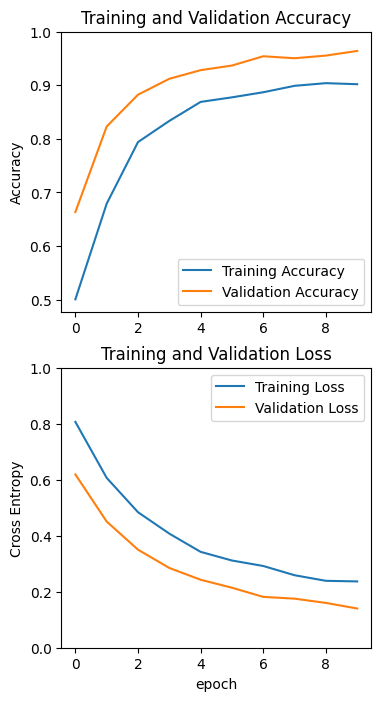

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(4, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

## One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [37]:
# Fine-tune from this layer onwards
fine_tune_at = 100

In [38]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [41]:
len(model.trainable_variables)
#These are typically the weights and biases within the layers of your neural network.

56

In [42]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 [==============================] - 28s 397ms/step - loss: 0.1559 - accuracy: 0.9330 - val_loss: 0.0633 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 24s 388ms/step - loss: 0.1341 - accuracy: 0.9480 - val_loss: 0.0378 - val_accuracy: 0.9889
Epoch 13/20
63/63 [==============================] - 24s 389ms/step - loss: 0.1158 - accuracy: 0.9545 - val_loss: 0.0389 - val_accuracy: 0.9901
Epoch 14/20
63/63 [==============================] - 25s 404ms/step - loss: 0.0999 - accuracy: 0.9605 - val_loss: 0.0375 - val_accuracy: 0.9889
Epoch 15/20
63/63 [==============================] - 25s 400ms/step - loss: 0.0997 - accuracy: 0.9645 - val_loss: 0.0413 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 27s 436ms/step - loss: 0.0868 - accuracy: 0.9645 - val_loss: 0.0439 - val_accuracy: 0.9827
Epoch 17/20
63/63 [==============================] - 27s 427ms/step - loss: 0.0743 - accuracy: 0.9715 - val_loss: 0.0375 - val_accuracy:

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

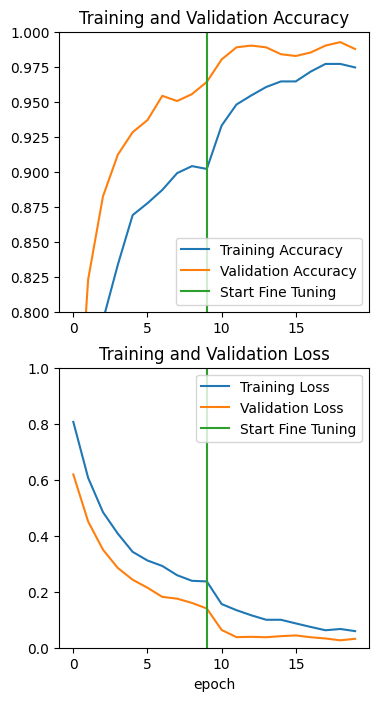

In [44]:
plt.figure(figsize=(4, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 235ms/step - loss: 0.0280 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Predictions:
 [0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0]
Labels:
 [0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0]


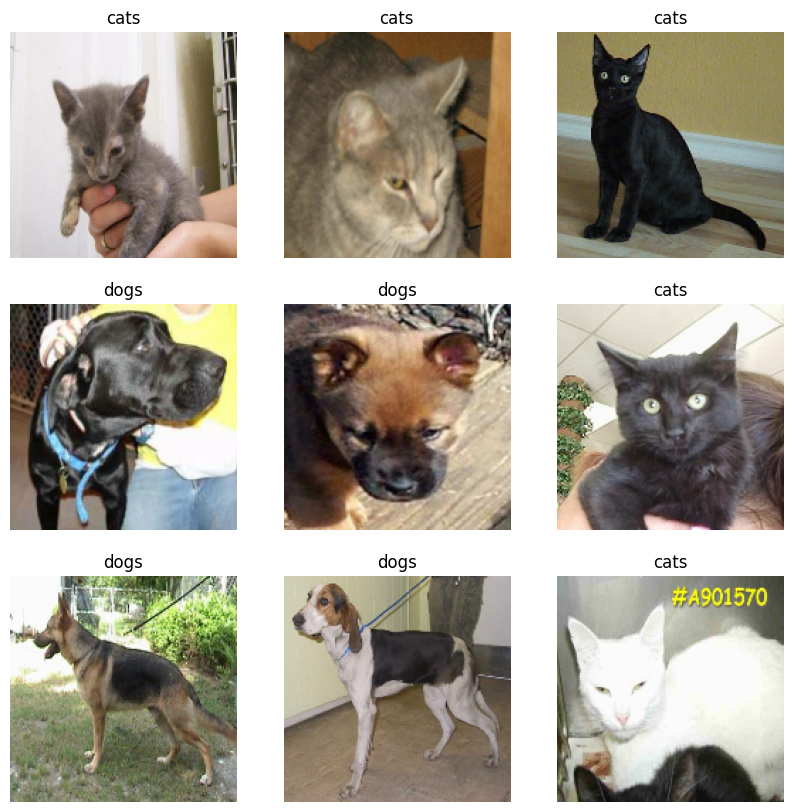

In [46]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")